In [1]:
# Auto loading
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import multiprocessing
import scipy.special
import numpy as np
import numpy.fft as fft
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')

In [3]:
from utils import to_radian,res_to_rad,ax_to_w,rep_to_angle
from rotation_3d import tricubic_derivatives,tricubic_interp
from rotation_3d import rot_cost_func_3d
from visualize import plot_cost_func
from cost_functions import cf_ssd
from mask import sphere_mask

In [4]:
sept23_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/sept23_dict_10.p','rb'))
sept23_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/sept23_dict_8.p','rb'))
sept23_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/sept23_dict_6_4.p','rb'))
oct13_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_10.p','rb'))
oct13_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_8.p','rb'))
oct13_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_6_4.p','rb'))

In [5]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Dropbox/THESIS/Sept_23_navs/'
ranges = ['0_5_to_2_5','3_0_to_5_0']
files = os.listdir(path)
axes_dict = {}
for f in files[1:]:
    rot_ax = f.split('_')[2]
    trans_ax = f.split('_')[10]
    if not axes_dict.has_key(rot_ax):
        axes_dict[rot_ax] = trans_ax
print axes_dict
print axes_dict.keys()

{'xz': 'xy', 'y': 'z', 'yz': 'xy', 'xy': 'xy', 'x': 'z', 'z': 'z'}
['xz', 'y', 'yz', 'xy', 'x', 'z']


Let $V^S$ denote the source volume, and $V^T$ denote the target volume.  We want to find a transformation from source to target so that their sum of squared difference is minimal. The cost function we have chosen is the sum of squared differences between the two volume at each voxel, defined as, 
$$f = \sum\limits_{i}(V^S(\boldsymbol{x_i}+\boldsymbol{d}(\boldsymbol{P}))-V^T)^2,$$ 
where $\boldsymbol{x_i}$ is the voxel location, and $\boldsymbol{d}(\boldsymbol{P})$ is the replacement from source to target given the set of parameters $\boldsymbol{P}$. We need to minimize this cost function with respect to the set of six transformation parameters $\boldsymbol{P}$. 

Gauss-Newton method allows us to find the minimum of a least squared function through iterative procedures. Let 
$$\begin{align}
r_i(\boldsymbol{P}) = V^S(\boldsymbol{x_i}+\boldsymbol{d}(\boldsymbol{P}))-V^T (1)
\end{align}$$

Then the iteration goes as follows,
$$\boldsymbol{P}^{s+1} = \boldsymbol{P}^{s} - \left(\mathbf{J_r}^\mathsf{T} \mathbf{J_r} \right)^{-1} \mathbf{ J_r} ^\mathsf{T} \mathbf{r}(\boldsymbol P^{s}),$$
where 

$$(\mathbf{J_r})_{ij} = \frac{\partial r_i (\boldsymbol P^{(s)})}{\partial P_j}$$

$$=\frac{\partial r_i (\boldsymbol P^{(s)})}{\partial \boldsymbol{d}(P_j)}\frac{\partial \boldsymbol{d}(P_j)}{\partial P_j}$$

Now the problem boils down to simplifying the computation for the Jacobian. If we take the gradient of $r_i(\boldsymbol{P})$ using equation (1) we get,

$$
\frac{\partial r_i (\boldsymbol{P})}{\partial P_j} = \nabla_{\boldsymbol{x}_i}\boldsymbol{V^S(\boldsymbol{x}_i)} \frac{\partial \boldsymbol{d}(P_j)}{\partial P_j}$$

where $\nabla_{\boldsymbol{x}_i}\boldsymbol{V^S(\boldsymbol{x}_i)}$ is the partial derivatives of the source volume at voxel $i$ with respect to the three coordinate directions, which is computed already during tricubic interpolation. Since the displacement between the two volumes are relatively small,  we can model the small rotations as a translation.

$$\boldsymbol{d(\boldsymbol{P})} = \boldsymbol{M}\boldsymbol{P},$$
where

$$
\boldsymbol{M} = 
\begin{bmatrix}
1 & 0 & 0 & 0 & x_3 & -x_2\\
0 & 1 & 0 & -x_3 & 0 & x_1\\
0 & 0 & 1 & x_2 & -x_1 & 0\\
\end{bmatrix}$$

Hence, 
$$\frac{\partial \boldsymbol{d}(P)}{\partial P} = \boldsymbol{M}$$
$$\frac{\partial \boldsymbol{d}(P)}{\partial P_j} = \boldsymbol{M}[:,j]$$
$$\frac{\partial r_i (\boldsymbol{P})}{\partial P_j} = \nabla_{\boldsymbol{x}_i}\boldsymbol{V^S(\boldsymbol{x}_i)} \boldsymbol{M}[:,j]$$

$$
(\mathbf{J_r})_{ij} = \nabla_{\boldsymbol{x}_i}\boldsymbol{V^S(\boldsymbol{x}_i)} \boldsymbol{M}[:,j]
$$

Notice that we still need to compute $\nabla_{\boldsymbol{x}}\boldsymbol{V^S}$ at each step for each voxel, which can be very expensive, so to save computation, we can calculate the displacement on the target volume $V^T$. 
Suppose now we pretend to move the target volume to the source volume instead, then
$$f = \sum\limits_{i}(V^T(\boldsymbol{x_i}+\boldsymbol{d}(\boldsymbol{P}))-V^S)^2,$$
and if we follow the steps we will end up with 
$$\boldsymbol{P}^{s+1} = \boldsymbol{P}^{s} - \left(\mathbf{J_r}^\mathsf{T} \mathbf{J_r} \right)^{-1} \mathbf{ J_r} ^\mathsf{T} \mathbf{r}(\boldsymbol P^{s}),$$
where 
$$(\mathbf{J_r})_{ij} = \nabla_{\boldsymbol{x}_i}\boldsymbol{V^T(\boldsymbol{x}_i)} \boldsymbol{M}[:,j]$$
We can now move $V^S$ by $-\boldsymbol{P}$, and continue with the iteration. This way, we only need to compute $\nabla_{\boldsymbol{x}_i}\boldsymbol{V^T(\boldsymbol{x}_i)} $ once, and in every iteration it remains constant.

In [345]:
derivatives = axis_derivatives(testVol1)

In [331]:
derivatives_old = axis_derivatives_old(testVol1)

In [343]:
i,j,k = 0,1,0
print derivatives_old[(i,j,k)]*100
print derivatives[j,i,k]*100

[-0.076675   -0.00509131 -0.08541622]
[-0.03967063 -0.01278381 -0.08835322]


In [333]:
xx,yy,zz = np.meshgrid(np.linspace(0,31,32),np.linspace(0,31,32),np.linspace(0,31,32))

In [346]:
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            #print i, j, k, xx[i,j,k],yy[i,j,k],zz[i,j,k]
            if not np.allclose(derivatives[j,i,k],derivatives_old[(i,j,k)]):
                print i, j, k

In [379]:
# Function to compute the derivatives for the target volume
def axis_derivatives(volume):
    shape = volume.shape
    xx,yy,zz = np.meshgrid(np.linspace(0,31,32),np.linspace(0,31,32),np.linspace(0,31,32))
    x1 = xx.astype(int)
    y1 = yy.astype(int)
    z1 = zz.astype(int)

    x0 = x1 - 1
    x2 = x1 + 1
    y0 = y1 - 1
    y2 = y1 + 1
    z0 = z1 - 1
    z2 = z1 + 1

    # wrap around
    x0 = (x0 + volume.shape[1]) % volume.shape[1]
    x2 = (x2 + volume.shape[1]) % volume.shape[1]
    y0 = (y0 + volume.shape[0]) % volume.shape[0]
    y2 = (y2 + volume.shape[0]) % volume.shape[0]
    z0 = (z0 + volume.shape[2]) % volume.shape[2]
    z2 = (z2 + volume.shape[2]) % volume.shape[2] 

    # Wrap around original grid points
    x1 = (x1 + volume.shape[1]) % volume.shape[1]
    y1 = (y1 + volume.shape[0]) % volume.shape[0]
    z1 = (z1 + volume.shape[2]) % volume.shape[2]
    
#     x0 = np.clip(x0, 0, volume.shape[1]-1)
#     x1 = np.clip(x1, 0, volume.shape[1]-1)
#     x2 = np.clip(x2, 0, volume.shape[1]-1)
#     y0 = np.clip(y0, 0, volume.shape[0]-1)
#     y1 = np.clip(y1, 0, volume.shape[0]-1)
#     y2 = np.clip(y2, 0, volume.shape[0]-1)
#     z0 = np.clip(z0, 0, volume.shape[2]-1)
#     z1 = np.clip(z1, 0, volume.shape[2]-1)
#     z2 = np.clip(z2, 0, volume.shape[2]-1)

    # Compute vector Y from known points
    Y = np.empty([32,32,32,3])

    # values of df/dx at each corner.
    Y[:,:,:,1] = ((volume[y1,x2,z1]-volume[y1,x0,z1])/2.)
    # values of df/dy at each corner.
    Y[:,:,:,0] = ((volume[y2,x1,z1]-volume[y0,x1,z1])/2.)
    # values of df/dz at each corner.
    Y[:,:,:,2] = ((volume[y1,x1,z2]-volume[y1,x1,z0])/2.)

    return Y

In [383]:
# Function to compute the derivatives for the target volume
def axis_derivatives_old(volume):
    shape = volume.shape
    tricubic_derivative_dict = {}
    for i in xrange(0,shape[0]):
        for j in xrange(0,shape[1]):
            for k in xrange(0,shape[2]):
                # Take care of boundary conditions
                x1 = i
                y1 = j
                z1 = k
                x0 = x1 - 1
                x2 = x1 + 1
                y0 = y1 - 1
                y2 = y1 + 1
                z0 = z1 - 1
                z2 = z1 + 1
                
#                     # Wrap Around
#                 x0 = (x0 + volume.shape[1]) % volume.shape[1]
#                 x2 = (x2 + volume.shape[1]) % volume.shape[1]
#                 y0 = (y0 + volume.shape[0]) % volume.shape[0]
#                 y2 = (y2 + volume.shape[0]) % volume.shape[0]
#                 z0 = (z0 + volume.shape[2]) % volume.shape[2]
#                 z2 = (z2 + volume.shape[2]) % volume.shape[2] 

#                 # Wrap around original grid points
#                 x1 = (x1 + volume.shape[1]) % volume.shape[1]
#                 y1 = (y1 + volume.shape[0]) % volume.shape[0]
#                 z1 = (z1 + volume.shape[2]) % volume.shape[2]
                
                x0 = np.clip(x0, 0, volume.shape[1]-1)
                x1 = np.clip(x1, 0, volume.shape[1]-1)
                x2 = np.clip(x2, 0, volume.shape[1]-1)
                y0 = np.clip(y0, 0, volume.shape[0]-1)
                y1 = np.clip(y1, 0, volume.shape[0]-1)
                y2 = np.clip(y2, 0, volume.shape[0]-1)
                z0 = np.clip(z0, 0, volume.shape[2]-1)
                z1 = np.clip(z1, 0, volume.shape[2]-1)
                z2 = np.clip(z2, 0, volume.shape[2]-1)

                # Compute vector Y from known points
                Y = np.zeros([3,])

                # values of df/dx at each corner.
                Y[1] = ((volume[y1,x2,z1]-volume[y1,x0,z1])/2.)
                # values of df/dy at each corner.
                Y[0] = ((volume[y2,x1,z1]-volume[y0,x1,z1])/2.)
                # values of df/dz at each corner.
                Y[2] = ((volume[y1,x1,z2]-volume[y1,x1,z0])/2.)

                tricubic_derivative_dict[(i,j,k)] = Y
    return tricubic_derivative_dict

In [451]:
def rotate_coords_transformation_m(x, y, z, params, ox,oy,oz, k=16.):
    l = np.sqrt(params[3]**2+params[4]**2+params[5]**2)/k
    if(l == 0):
        return (x+params[1],y+params[0],z+params[2])
    s,c = np.sin(l/2.),np.cos(l/2.)
    alpha = c
    beta = s*params[4]/l
    gamma = s*params[3]/l
    delta = s*params[5]/l
    x, y, z = x - ox, y - oy, z - oz
    rotx = (alpha**2+beta**2-gamma**2-delta**2)*x+2*(beta*gamma-alpha*delta)*y+2*(beta*delta+alpha*gamma)*z+ox+params[1]
    roty = (alpha**2-beta**2+gamma**2-delta**2)*y+2*(beta*gamma+alpha*delta)*x+2*(gamma*delta-alpha*beta)*z+oy+params[0]
    rotz = (alpha**2-beta**2-gamma**2+delta**2)*z+2*(gamma*delta+alpha*beta)*y+2*(beta*delta-alpha*gamma)*x+oz+params[2]

    return (rotx,roty,rotz)

In [394]:
def get_M(x1_org,x2_org,x3_org,k=16.):
    x1 = x1_org/k
    x2 = x2_org/k
    x3 = x3_org/k
    M = np.array([[1,0,0,0,x3,-x2],[0,1,0,-x3,0,x1],[0,0,1,x2,-x1,0]])
    return M

In [395]:
def to_degree(radian):
    return radian*180/np.pi

def trace_plot(Ps,res):
    arr = np.array(Ps)
    plt.figure(figsize = [12,4])
    plt.subplot(1,2,1)
    for i in xrange(3):
        plt.plot(arr[:,i]*res,label = 't_%s'%i)
    plt.legend(loc = 'best')
    plt.xlabel('Iterations', fontsize = 15)
    plt.ylabel('Translations (mm)', fontsize = 15)
    plt.subplot(1,2,2)
    for j in xrange(3,6):
        plt.plot(to_degree(arr[:,j]),label = 'R_%s'%j)
    plt.legend(loc = 'best')
    plt.suptitle('Trace Plot for the Transformation Parameters',fontsize=18)
    plt.xlabel('Iterations', fontsize = 15)
    plt.ylabel('Rotations (degrees)', fontsize = 15)
    plt.show()
    
def plot_errors(errors):
    plt.plot(errors[1:])
    plt.title('Trace Plot for Errors',fontsize = 18)
    plt.xlabel('Iterations', fontsize = 15)
    plt.ylabel('SSD Error', fontsize = 15)
    plt.show()
    
def convert_params(params,res):
    print 'translation (in mm):', params[:3]*res
    print 'rotations (in degrees):', params[3:]*180/np.pi
    
def print_results(errors, Ps, res):
    print 'min error: ', errors[-1]
    params = Ps[-1]
    print 'parameters at min error: ', params
    print 'translation (in mm):', params[:3]*res
    print 'rotations (in degrees):', params[3:]*180/np.pi

In [352]:
# Get two volumes to register
rot_ax = 'x'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
# mask the volumes
testVol1_masked = sphere_mask(testVol1,rad)
testVol2_masked = sphere_mask(testVol2,rad)

# Get the mesh_grid points for the volume
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
# Precompute some information for gd
volume_shape = testVol2_masked.shape
ox = volume_shape[1]/2.-0.5
oy = volume_shape[0]/2.-0.5
oz = volume_shape[2]/2.-0.5
derivatives_masked = axis_derivatives(testVol1_masked)
tricubic_cache_masked = tricubic_derivatives(testVol2_masked)
#derivatives = axis_derivatives(testVol1)
#tricubic_cache = tricubic_derivatives(testVol2)

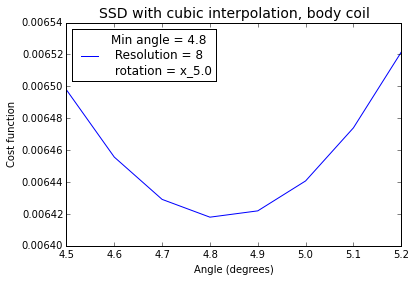

In [353]:
# Test tricubic interpolation on 8mm, x-axis rotation
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))

thetas = np.arange(4.5,5.2,0.1)
wx,wy,wz = ax_to_w(rot_ax)
cost = rot_cost_func_3d(testVol1_masked, testVol2_masked, thetas, wx,wy,wz,xx,yy,zz,interpolation = 'tricubic')
plot_cost_func(thetas,cost,res,'cubic','%s_5.0'%rot_ax, 'body')

**Step 1: Compare derivatives of image 1 with respect to the coordinate axes **

In [15]:
img1Derivs = np.array(np.memmap('/Users/zyzdiana/Downloads/forDiana/img1Derivs.dat', dtype=np.float32, mode='c', shape=(3,32,32,32)))
img2Derivs = np.array(np.memmap('/Users/zyzdiana/Downloads/forDiana/img2Derivs.dat',dtype=np.float32,mode='c',shape=(3,32,32,32)))

In [162]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(img1Derivs[:,i,j,k], -1.*derivatives[(j,i,k)]):
                count += 1
                print i,j,k
print count

0


In [163]:
derivatives_vol2 = axis_derivatives(testVol2)
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(img2Derivs[:,i,j,k], -1.*derivatives_vol2[(j,i,k)]):
                count += 1
                print i,j,k
print count

0


**Step 2: Compare M Tensor and img1Gradiaent**

In [59]:
img1GradP = np.array(np.memmap('/Users/zyzdiana/Downloads/forDiana/img1GradP.dat', dtype=np.float32, mode='c', shape=(32,32,32,6)))
MTensor = np.array(np.memmap('/Users/zyzdiana/Downloads/forDiana/MTensor.dat',dtype=np.float32,mode='c',shape=(32,32,32,6,3)))

In [105]:
MT = np.empty([32,32,32,6,3])
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            M = get_M(yy[i,j,k]-15.5,xx[i,j,k]-15.5,zz[i,j,k]-15.5)
            MT[i,j,k,:,:] = M.T

In [164]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(MTensor[i,j,k,:,:], MT[i,j,k,:,:]):
                count += 1
                print i,j,k
print count

0


In [165]:
count = 0
for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            if not np.allclose(MT[i,j,k,:,:].dot(-derivatives[j,i,k]),img1GradP[i,j,k,:],1e-5,1e-7):
                count += 1
                print i,j,k
print count

0


In [166]:
img1GradP[i,j,k,:].shape

(6,)

**Step 3: Compare JTransJ and JTransr**

In [127]:
JTransJ = np.array(np.memmap('/Users/zyzdiana/Downloads/forDiana/JTransJ.dat',dtype=np.float32,mode='c',shape=(6,6)))

In [189]:
jTj = np.zeros([6,6])
jTr = np.zeros([6,1])
r = testVol2-testVol1

for i in xrange(32):
    for j in xrange(32):
        for k in xrange(32):
            tmp = (MT[i,j,k,:,:].dot(-derivatives[j,i,k])).reshape([1,6])
            jTj += tmp.T.dot(tmp)
            jTr -= tmp.T*(r[i,j,k])

In [190]:
np.allclose(jTj,JTransJ)

True

In [191]:
jTr

array([[-0.05516286],
       [-0.01742106],
       [ 0.00436957],
       [-0.07831883],
       [ 0.16866634],
       [-0.49359507]])

In [194]:
np.linalg.solve(jTj,jTr)

array([[-0.11947555],
       [-0.04306539],
       [ 0.02137844],
       [ 0.00104204],
       [-0.00155372],
       [-0.04679049]])

In [32]:
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)

# Get the mesh_grid points for the volume
xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))

In [396]:
# Get two volumes to register
rot_ax = 'z'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]

# mask the volumes
testVol1_masked = sphere_mask(testVol1,rad)
testVol2_masked = sphere_mask(testVol2,rad)

derivatives_masked = axis_derivatives(testVol1_masked)
tricubic_cache_masked = tricubic_derivatives(testVol2_masked)

# Precompute some information for gd
volume_shape = testVol2_masked.shape
ox = volume_shape[1]/2.-0.5
oy = volume_shape[0]/2.-0.5
oz = volume_shape[2]/2.-0.5

In [397]:
P_s = np.array([0,0,0,0,0,0])
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz)
dest = np.empty(volume_shape)
for i in xrange(volume_shape[0]):
    for j in xrange(volume_shape[1]):
        for k in xrange(volume_shape[2]):
            dest[i,j,k] = tricubic_interp(volume_shape,tricubic_cache_masked,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
print cf_ssd(dest,testVol1_masked)

0.0125651922879


In [398]:
P_s = np.array([0,0,0,0,0,-to_radian(5)])
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz)
dest = np.empty(volume_shape)
for i in xrange(volume_shape[0]):
    for j in xrange(volume_shape[1]):
        for k in xrange(volume_shape[2]):
            dest[i,j,k] = tricubic_interp(volume_shape,tricubic_cache_masked,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
print cf_ssd(dest,testVol1_masked)

0.00505054067392


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

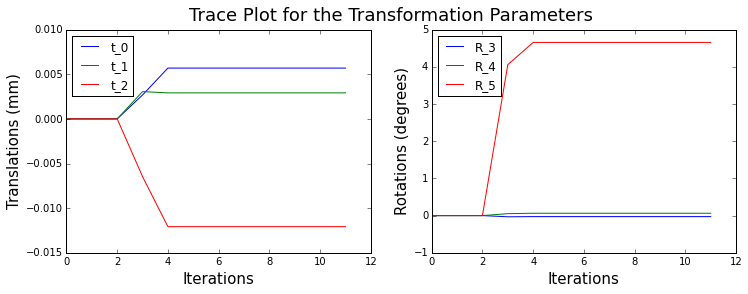

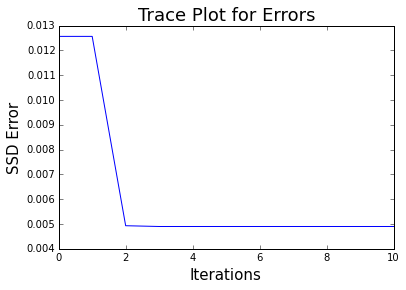

 min error:  0.00489957817124
parameters at min error:  [ 0.00071113  0.00036421 -0.00150915 -0.00047599  0.0010994   0.08125279]
translation (in mm): [ 0.00568901  0.0029137  -0.01207319]
rotations (in degrees): [-0.02727244  0.06299093  4.65544199]


In [399]:
errors_z, Ps_z = Gauss_Newton(testVol1_masked,derivatives_masked,testVol2_masked,tricubic_cache_masked)
print_results(errors_z, Ps_z, 8)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

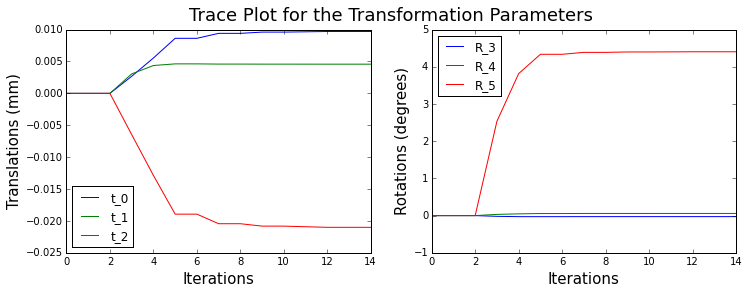

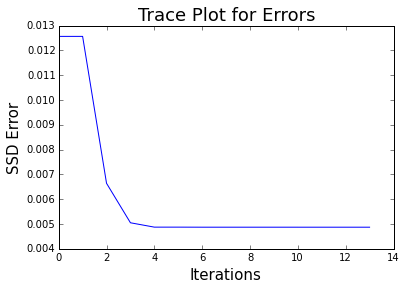

 min error:  0.00487123527822
parameters at min error:  [ 0.00121297  0.00057242 -0.00262577 -0.00047794  0.00100875  0.07686399]
translation (in mm): [ 0.00970375  0.00457936 -0.02100614]
rotations (in degrees): [-0.02738382  0.05779735  4.40398231]


In [400]:
errors_z, Ps_z = Gauss_Newton(testVol1_masked,derivatives_masked,testVol2_masked,tricubic_cache_masked,divide_factor = 10.)
print_results(errors_z, Ps_z, 8)

In [170]:
# Get two volumes to register
rot_ax = 'y'
testVol1 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)]
testVol2 = sept23_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)]

# mask the volumes
testVol1_masked = sphere_mask(testVol1,rad)
testVol2_masked = sphere_mask(testVol2,rad)

derivatives_masked = axis_derivatives(testVol1_masked)
tricubic_cache_masked = tricubic_derivatives(testVol2_masked)

# Precompute some information for gd
volume_shape = testVol2_masked.shape
ox = volume_shape[1]/2.-0.5
oy = volume_shape[0]/2.-0.5
oz = volume_shape[2]/2.-0.5

In [123]:
P_s = np.array([0,0,0,0,-to_radian(5),0])
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz)
dest = np.empty(volume_shape)
for i in xrange(volume_shape[0]):
    for j in xrange(volume_shape[1]):
        for k in xrange(volume_shape[2]):
            dest[i,j,k] = tricubic_interp(volume_shape,tricubic_cache_masked,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
print cf_ssd(dest,testVol1_masked)

0.00469517912784


In [ ]:
errors_z, Ps_z = Gauss_Newton(testVol1_masked,derivatives_masked,testVol2_masked,tricubic_cache_masked)
print_results(errors_z, Ps_z, 8)

In [401]:
def get_volume(res, rot_ax, rang_id, rot_angle, mask = True):
    if('10' in res): dict_ = oct13_dict_10
    if('8' in res): dict_ = oct13_dict_8
    if('6_4' in res): dict_ = oct13_dict_6_4
    rad = res_to_rad(res)
    vol = dict_[rot_ax][axes_dict[rot_ax]][ranges[rang_id]][rot_angle]
    vol_filtered = abs(fft.ifftn(fft.ifftshift(sphere_mask(fft.fftshift(fft.fftn(vol)),rad))))
    if(mask):
        return sphere_mask(vol_filtered,rad)
    else:
        return vol_filtered

In [215]:
%%time
# Calculate the radius for masking
res = '8'
rot_ax = 'x'

# Get two volumes to register
testVol1_rot = get_volume(res,rot_ax,1,(0.0,5))
testVol2_rot = get_volume(res,rot_ax,1,(5.0,5))

vol1_dervs_rot = axis_derivatives(testVol1_rot)
vol2_dervs_rot = tricubic_derivatives(testVol2_rot)

CPU times: user 46.4 s, sys: 1.14 s, total: 47.6 s
Wall time: 48.2 s


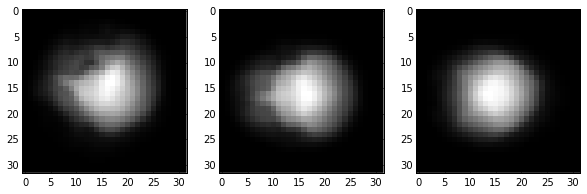

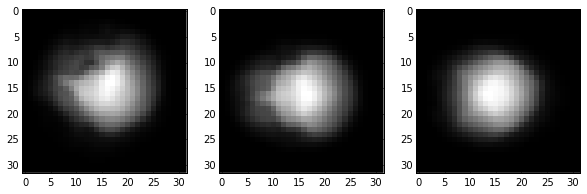

In [216]:
fig,ax = plt.subplots(1,3)
fig.set_figwidth(10)
fig.set_figheight(3)
[ax[i].imshow(testVol1_rot.max(axis=i), interpolation='None',cmap='gray') for i in xrange(3)]
plt.show()
plt.close(fig)
fig,ax = plt.subplots(1,3)
fig.set_figwidth(10)
fig.set_figheight(3)
[ax[i].imshow(testVol1_rot.max(axis=i), interpolation='None',cmap='gray') for i in xrange(3)]
plt.show()
plt.close(fig)

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 Converged in 18 iterations!


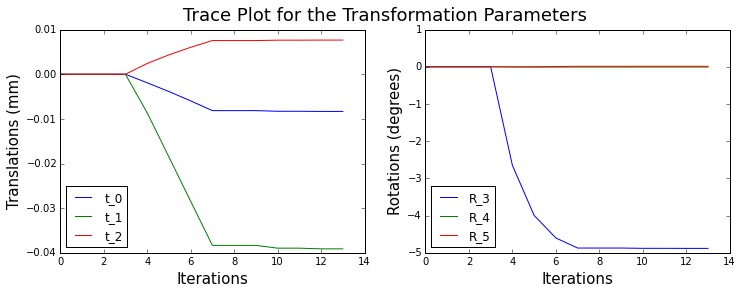

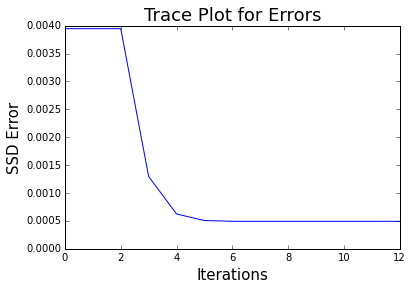

min error:  0.000492666811877
parameters at min error:  [-0.00104126 -0.0048895   0.00095663 -0.08519947 -0.00011854  0.00023785]
translation (in mm): [-0.00833006 -0.03911604  0.00765307]
rotations (in degrees): [-4.88157002 -0.00679157  0.01362771]


In [218]:
# 5 deg rotation in y axis
errors, Ps = Gauss_Newton(testVol1_rot,vol1_dervs_rot,testVol2_rot,vol2_dervs_rot,divide_factor = 16.,alpha=0.5,max_iter = 30)
print_results(errors, Ps, 8)

In [387]:
# Calculate the radius for masking
res = '8'
rot_ax = 'x'

# Get two volumes to register
testVol1_trans = get_volume(res,rot_ax,1,(0.0,0))
testVol2_trans = get_volume(res,rot_ax,1,(0.0,5))

vol1_dervs_trans = axis_derivatives(testVol1_trans)
vol2_dervs_trans = tricubic_derivatives(testVol2_trans)

In [250]:
print cf_ssd(testVol1_trans,testVol2_trans)
wx_t, wy_t, wz_t = ax_to_w(axes_dict[rot_ax])
print wx_t, wy_t, wz_t

trans = np.arange(-1,1,0.01)
cost = trans_cost_func_3d(testVol1_trans,testVol2_trans,trans,wx_t, wy_t, wz_t,3,True)
print np.min(cost)
print trans[np.argmin(cost)], 'voxel'
print trans[np.argmin(cost)]*8., 'mm'

0.00691082770955
0 0 -1
0.000713894558689
0.39 voxel
3.12 mm


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 Converged in 27 iterations!


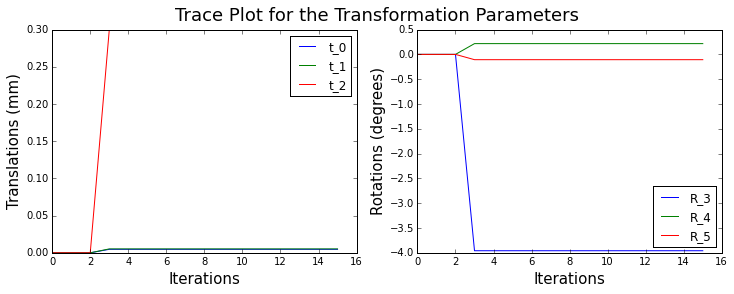

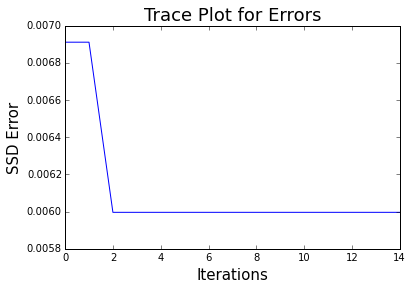

min error:  0.00599607500437
parameters at min error:  [ 0.00058473  0.0006547   0.03745139 -0.06908454  0.00379423 -0.00185869]
translation (in mm): [ 0.00467784  0.00523759  0.29961112]
rotations (in degrees): [-3.95825258  0.21739325 -0.10649534]


In [392]:
# 5 deg rotation in y axis
errors, Ps = Gauss_Newton(testVol1_trans,vol1_dervs_trans,testVol2_trans,vol2_dervs_trans, divide_factor = 16.,alpha=0.5,max_iter = 30)
print_results(errors, Ps, 8)

In [263]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

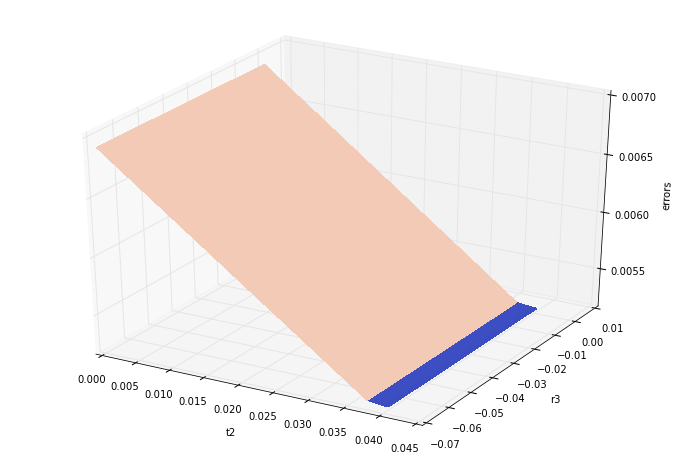

In [276]:
params_array = np.array(Ps)

fig = plt.figure(figsize=[12,8])
ax = fig.gca(projection='3d')
X = params_array[1:,2]
Y = params_array[1:,3]
X, Y = np.meshgrid(X, Y)
Z = errors[1:]

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_xlabel('t2')
ax.set_ylabel('r3')
ax.set_zlabel('errors')

#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [402]:
# Calculate the radius for masking
res = '8'
rot_ax = 'x'

# Get two volumes to register
testVol1_trans_nomask = get_volume(res,rot_ax,1,(0.0,0),True)
testVol2_trans_nomask = get_volume(res,rot_ax,1,(0.0,5),False)

vol1_dervs_trans_nomask = axis_derivatives(testVol1_trans_nomask)
vol2_dervs_trans_nomask = tricubic_derivatives(testVol2_trans_nomask)

In [418]:
P_s = np.array([0,0,0,0,0,0])
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz)
dest = np.empty(volume_shape)
for i in xrange(volume_shape[0]):
    for j in xrange(volume_shape[1]):
        for k in xrange(volume_shape[2]):
            dest[i,j,k] = tricubic_interp(volume_shape,vol2_dervs_trans_nomask,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
print cf_ssd(sphere_mask(dest,rad),testVol1_trans_nomask)

0.00691082770955


In [421]:
P_s = np.array([0,0,5./8.,0,0,0])
dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, P_s, ox, oy, oz)
dest = np.empty(volume_shape)
for i in xrange(volume_shape[0]):
    for j in xrange(volume_shape[1]):
        for k in xrange(volume_shape[2]):
            dest[i,j,k] = tricubic_interp(volume_shape,vol2_dervs_trans_nomask,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
print cf_ssd(sphere_mask(dest,rad),testVol1_trans_nomask)

0.000234305786923


In [266]:
print cf_ssd(testVol1_trans_nomask,testVol2_trans_nomask)
wx_t, wy_t, wz_t = ax_to_w(axes_dict[rot_ax])
print wx_t, wy_t, wz_t

trans = np.arange(-1,1,0.01)
cost = trans_cost_func_3d(testVol1_trans_nomask,testVol2_trans_nomask,trans,wx_t, wy_t, wz_t,3,True)
print np.min(cost)
print trans[np.argmin(cost)], 'voxel'
print trans[np.argmin(cost)]*8., 'mm'

0.0465155165979
0 0 -1
0.000218809703264
0.61 voxel
4.88 mm


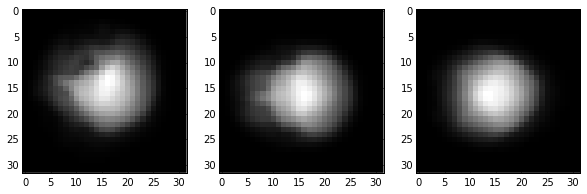

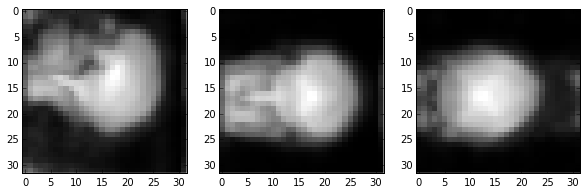

In [348]:
fig,ax = plt.subplots(1,3)
fig.set_figwidth(10)
fig.set_figheight(3)
[ax[i].imshow(testVol1_trans_nomask.max(axis=i), interpolation='None',cmap='gray') for i in xrange(3)]
plt.show()
plt.close(fig)
fig,ax = plt.subplots(1,3)
fig.set_figwidth(10)
fig.set_figheight(3)
[ax[i].imshow(testVol2_trans_nomask.max(axis=i), interpolation='None',cmap='gray') for i in xrange(3)]
plt.show()
plt.close(fig)

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 Converged in 19 iterations!


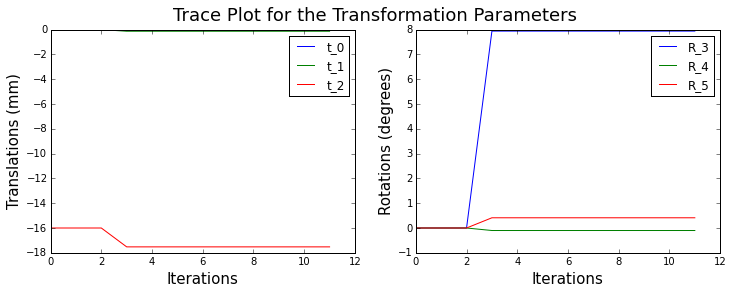

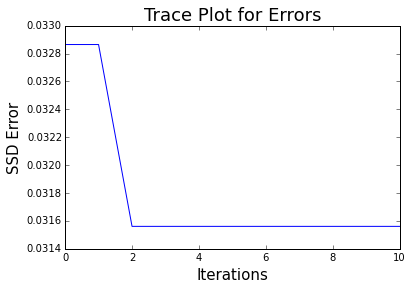

min error:  0.0315608328252
parameters at min error:  [ -1.24689760e-03  -1.64806779e-02  -2.19024365e+00   1.38586153e-01
  -1.76634409e-03   7.19282993e-03]
translation (in mm): [ -9.97518082e-03  -1.31845423e-01  -1.75219492e+01]
rotations (in degrees): [ 7.94040166 -0.10120406  0.4121188 ]


In [455]:
# 5 deg rotation in y axis
P_initial = np.array([0,0,-2,0,0,0])
errors, Ps = Gauss_Newton(testVol1_trans_nomask,vol1_dervs_trans_nomask,
                          testVol2_trans_nomask,vol2_dervs_trans_nomask, 
                          divide_factor = 16.,alpha=1.,P_initial = P_initial,max_iter = 30,mask=True)
print_results(errors, Ps, 8)

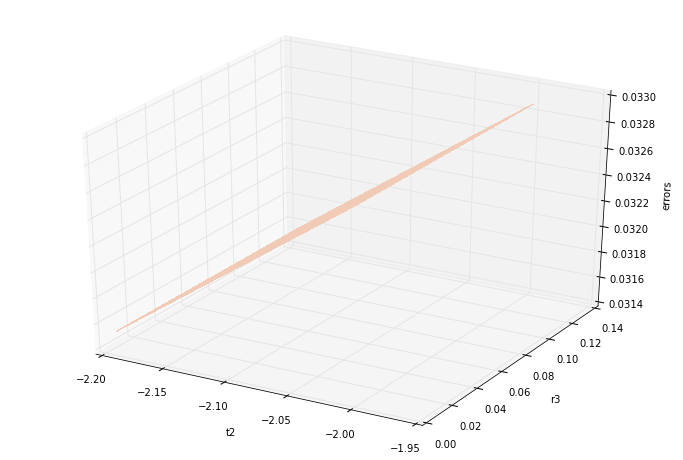

In [456]:
params_array = np.array(Ps)

fig = plt.figure(figsize=[12,8])
ax = fig.gca(projection='3d')
X = params_array[1:,2]
Y = params_array[1:,3]
X, Y = np.meshgrid(X, Y)
Z = errors[1:]

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_xlabel('t2')
ax.set_ylabel('r3')
ax.set_zlabel('errors')

#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [425]:
def Gauss_Newton(Vol1, Vol1_derivatives, Vol2, Vol2_derivatives, 
                 divide_factor = 16., alpha = 0.2, decrease_factor = 0.25, 
                 P_initial = np.array([0,0,0,0,0,0]), plot = True, max_iter = 20, mask = False):

    volume_shape = Vol1.shape
    if (volume_shape[0] == 26): res = '10'
    if (volume_shape[0] == 32): res = '8'
    if (volume_shape[0] == 40): res = '6_4'
    rad = volume_shape[0]/2
    xx,yy,zz = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/for_cluster/mesh_grid_%s.p'%res,'rb'))
    #if(mask):
        #Vol1 = sphere_mask(Vol1,rad)
    ox = volume_shape[1]/2.-0.5
    oy = volume_shape[0]/2.-0.5
    oz = volume_shape[2]/2.-0.5
    Ps = []
    P_old = P_initial.copy()
    P_new = P_old.copy()
    Ps.append(P_new)
    errors = []
    errors.append(1.0)
    
    for counter in xrange(max_iter):
        print counter,
        #print P_s
        P_old = P_new.copy()
        
        # Get the new coordinates by rotating the volume by the opposite amount of P_s
        dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, -1.*P_old, ox, oy, oz,divide_factor)
        #print dest_x
        # Initilization
        Jr = np.empty([volume_shape[0]*volume_shape[1]*volume_shape[2],6])
        Jr_rP = np.zeros([6,])
        dest = np.empty(volume_shape)
        idx = 0
        #Mtensor = np.empty([volume_shape[0],volume_shape[0],volume_shape[0],3,6])
        for i in xrange(volume_shape[0]):
            for j in xrange(volume_shape[1]):
                for k in xrange(volume_shape[2]):
                    dest[i,j,k] = tricubic_interp(volume_shape,Vol2_derivatives,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k])
                    M = get_M(yy[i,j,k]-ox,xx[i,j,k]-oy,zz[i,j,k]-oz,divide_factor)
                    for ii in xrange(len(P_old)):
                        Jr[idx,ii] = -1.*Vol1_derivatives[i,j,k].dot(M[:,ii])
                    idx += 1
        if(mask):
            dest = sphere_mask(dest,rad)
        flatR = np.ravel(Vol1-dest)
        Jr_rP = Jr.T.dot(flatR)
        
        error = cf_ssd(Vol1,dest)

        ## if error is getting larger, go back one step and decrease alpha
        if(error > errors[-1]):
            alpha = alpha * decrease_factor
            P_new = Ps[-1]
        else:
            #print abs(error-errors[-1])
            errors.append(error)
            Ps.append(P_old)
            P_new = P_old - alpha*np.dot(np.linalg.inv(np.dot(Jr.T,Jr)),Jr_rP)
            if((abs(P_new - P_old) < 1e-5).all()):
                print 'Converged in %s iterations!' % counter
                break
    if(plot):
        trace_plot(Ps, float('.'.join(res.split('_'))))
        plot_errors(errors)
    return errors, Ps

0

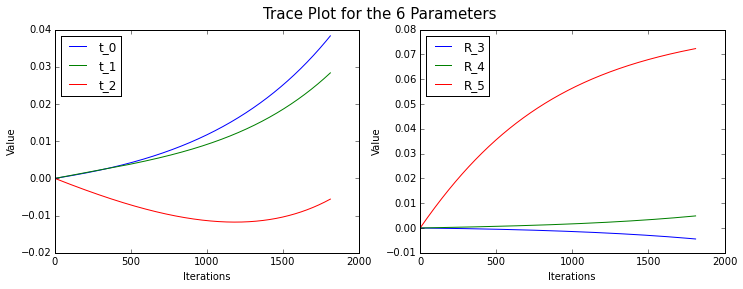

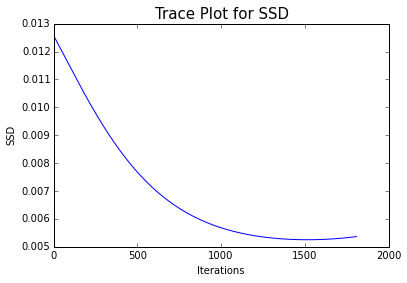

In [246]:
#Ps = []
alpha = 0.001

#P_s = np.array([0,0,0,0,0,0])
#P_s1 = P_s.copy()
#Ps.append(P_s1)
#errors = []
for counter in xrange(10):
    if(counter % 10 == 0):
        print counter,
    P_s = P_s1.copy()
    # Get the new coordinates by rotating the volume by the opposite amount of P_s
    dest_x, dest_y, dest_z = rotate_coords_transformation_m(xx, yy, zz, -1.*P_s, ox, oy, oz)
    # Initilization
    Jr = np.empty([volume_shape[0]*volume_shape[1]*volume_shape[2],6])
    Jr_rP = np.zeros([6,])
    dest = np.empty(volume_shape)
    idx = 0
    for i in xrange(volume_shape[0]):
        for j in xrange(volume_shape[1]):
            for k in xrange(volume_shape[2]):
                dest[i,j,k] = tricubic_interp(volume_shape,tricubic_cache_masked,dest_x[i,j,k],dest_y[i,j,k],dest_z[i,j,k]) 
                M = get_M(yy[i,j,k]-ox,xx[i,j,k]-oy,zz[i,j,k]-oz)
                for ii in xrange(len(P_s)):
                    Jr[idx,ii] = -1.*derivatives_masked[j,i,k].dot(M[:,ii])
                    Jr_rP[ii] += Jr[idx,ii]*(testVol1_masked[yy[i,j,k],xx[i,j,k],zz[i,j,k]]-dest[i,j,k])
                idx += 1
    errors.append(cf_ssd(testVol1_masked,dest))
    P_s1 = P_s - alpha*np.dot(np.linalg.inv(np.dot(Jr.T,Jr)),Jr_rP)
    Ps.append(P_s1)
trace_plot(Ps)
plot_errors(errors)

In [247]:
print_results(errors, Ps, 8)

min error:  0.00525287564177
parameters at min error:  [ 0.02570064  0.0190052  -0.01021305 -0.00303911  0.0033868   0.06817436]
translation (in mm): [ 0.20560511  0.1520416  -0.08170441]
rotations (in degrees): [-0.17412798  0.19404954  3.90610291]


In [248]:
from scipy import ndimage
def trans_cost_func_3d(vol1, vol2, trans, wx, wy, wz,order=1,mask = True):
    '''
    vol1: original image
    vol2: volume to be rotated
    thetas: list of degress to try
    arg: string for plot titles
    '''
    if mask:
        rad = vol1.shape[0]/2
        vol1_masked = sphere_mask(vol1,rad)
    cost_func = np.zeros([len(trans),])
    for idx, t in enumerate(trans):
        new_vol2 = scipy.ndimage.interpolation.shift(vol2,np.array([wx,wy,wz])*t,order=order, mode='wrap')
        if mask:
            cost_func[idx] = cf_ssd(sphere_mask(new_vol2,rad),vol1_masked)
        else:
            cost_func[idx] = cf_ssd(new_vol2,vol1)
    return cost_func